## Image Fitting in Sherpa:  Accounting for the PSF effect

Images can be easily fit in Sherpa. In the following example we show how to include the PSF in the modeling of the central source. The X-ray Chandra image data are modeled with the gaussian shape that accounts for the point source emission (quasar in this case) and a constant for the background. We ignore the region of the image with the additional structure in the vicinity of a point source. 

In [1]:
from sherpa.astro.ui import *
from IPython.core.display import Image
import numpy as np

After importing Sherpa package we define the statistics and an optimization method. X-ray counts are modeled using
a Poisson likelihood defined via Cash (1979) and we will use Monte Carlo (differential evolution algorithm) implemented in Sherpa.

In [2]:
set_stat("cash")
set_method('moncar')

We first load the X-ray fits image first and then the PSF image which matches the binning of the X-ray image.

In [3]:
load_image("image.fits")

In [5]:
load_psf("mypsf", "psf.fits")
set_psf(mypsf)
print(get_psf())

psfmodel.mypsf
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   mypsf.kernel frozen     psf.fits
   mypsf.size   frozen     (33, 33)     (33, 33)     (33, 33)
   mypsf.center frozen     (16, 16)     (16, 16)     (16, 16)
   mypsf.radial frozen            0            0            1           
   mypsf.norm   frozen            1            0            1           


PSF image is defined as 'mypsf' and the source model will be convolved with this psf image during the fit. The center of the PSF image needs to be redefined to the central location on the pixel.

In [6]:
mypsf.center = (17.0,17.0)

Gaussian model (gauss2d) and a constant (const2d) are set to model the image. Note that these two models are named
q1 and c0 in this Sherpa session.

In [7]:
set_model(gauss2d.q1+const2d.c0)
guess(q1)

We display the data with ds9 (the ds9 window will appear outside the browser) and set the filter to ignore the extension around the point source.

In [8]:
image_data()

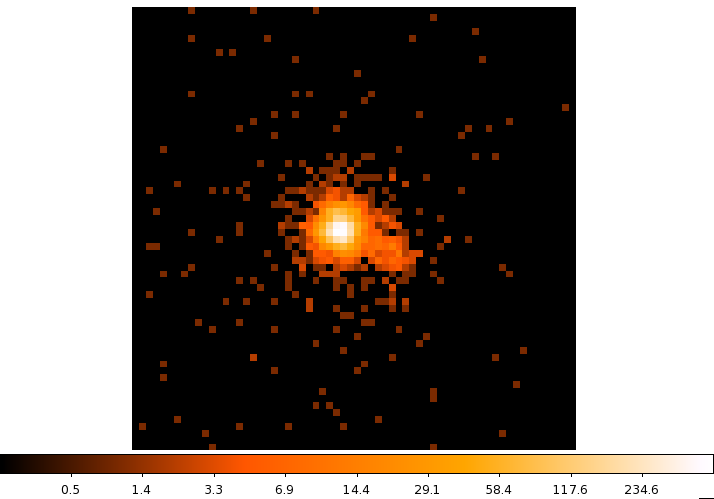

In [9]:
Image('ds9_data.png')

In [10]:
set_coord("physical")
ignore2d("ignore.reg")
set_coord("logical")
image_data()

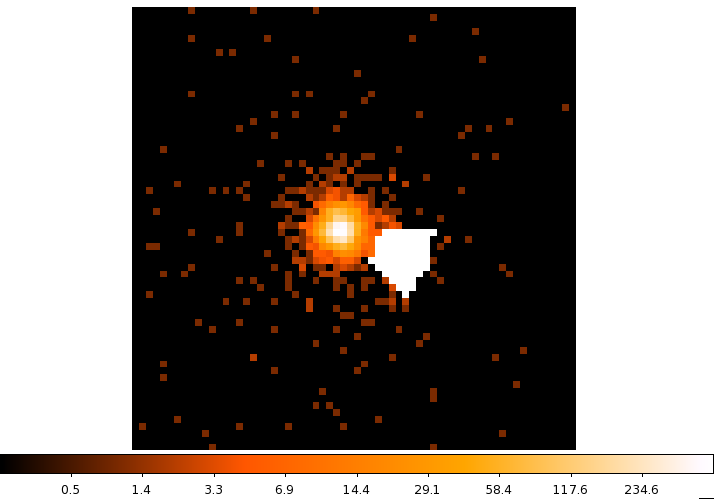

In [11]:
Image('ds9_data_filter.png')

In [12]:
fit()

Dataset               = 1
Method                = moncar
Statistic             = cash
Initial fit statistic = -24457.7
Final fit statistic   = -36126 at function evaluation 6356
Data points           = 4033
Degrees of freedom    = 4028
Change in statistic   = 11668.3
   q1.fwhm        1.5257      
   q1.xpos        30.7363     
   q1.ypos        32.6549     
   q1.ampl        1911.78     
   c0.c0          0.0241046   


In [13]:
notice2d()
image_fit()

Using notice2d we delete the filter and display the results from the fit in three ds9 panels: data, model and the residuals map. The residuals show the remaining structures not defined in our model.

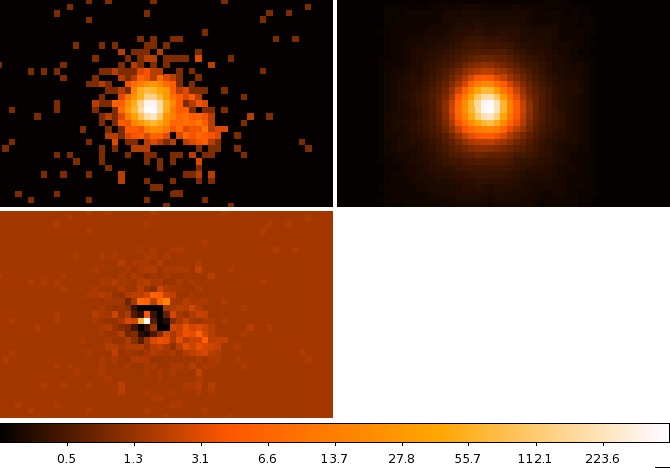

In [14]:
Image('ds9_fit.png')

In [16]:
get_model()

<ConvolutionModel model instance 'psfmodel.mypsf((gauss2d.q1 + const2d.c0))'>

Next step in the analysis we will calculate the uncertainties on the best fit model parameters using "get_draws" sampling function. "get_draws" is an implementation of Bayesian MCMC sampler in Sherpa. We assume the Metropolis-Hastings conditions and start at the best fit parameter values. We need to addjust the min/max ranges and use the flat priors for all the parameters within the valid min/max range. Only thaw parameters will have the sampling arrays.

In [17]:
set_par(q1.fwhm,min=0.1, max = 5)
set_par(q1.ampl, min=1.0, max=100000)
set_par(c0.c0,min=1e-4,max=1)
covar()

Dataset               = 1
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = moncar
Statistic             = cash
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   q1.fwhm            1.5257   -0.0392672    0.0392672
   q1.xpos           30.7363   -0.0200834    0.0200834
   q1.ypos           32.6549   -0.0204192    0.0204192
   q1.ampl           1911.78     -99.9908      99.9908
   c0.c0           0.0241046  -0.00273333   0.00273333


In [18]:
set_sampler_opt('scale',0.1)

In [19]:
stats, accept, params = get_draws(niter=10000)

Using Priors:
q1.fwhm: <function flat at 0x7f8070617670>
q1.xpos: <function flat at 0x7f8070617670>
q1.ypos: <function flat at 0x7f8070617670>
q1.ampl: <function flat at 0x7f8070617670>
c0.c0: <function flat at 0x7f8070617670>


In [23]:
print(np.sum(accept))
numiter = 10000
100.0*np.sum(accept)/float(numiter)

4118


41.18

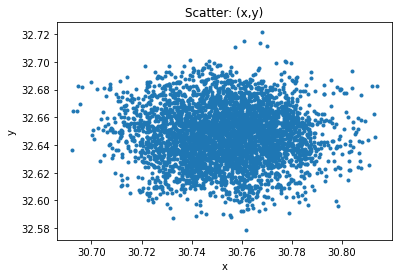

In [24]:
ok = accept == True
plot_scatter(params[1][ok],params[2][ok])

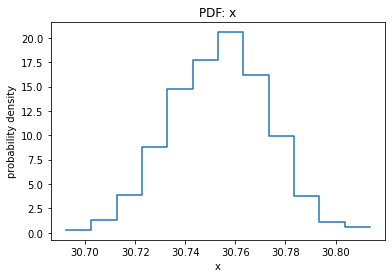

In [25]:
plot_pdf(params[1][ok])